## Description

**Author: Łukasz Łaszczuk**

This notebook focuses on training decision trees and tuning it for detecting fraudulent credit card transactions.

## Import modules and data

In [354]:
import copy
import warnings
import pydotplus
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb

In [352]:
from sklearn.model_selection import (learning_curve, RandomizedSearchCV,
                                     StratifiedShuffleSplit, StratifiedKFold,
                                     train_test_split,
                                    )
from sklearn.metrics import (accuracy_score, average_precision_score,
                             classification_report, confusion_matrix,
                             f1_score, precision_recall_curve,
                             precision_score, recall_score, 
                             roc_auc_score, roc_curve,
                            )
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.base import clone
from scikitplot.metrics import plot_precision_recall
from joblib import dump, load
from io import StringIO
from ipywidgets import Image

In [3]:
%config InlineBackend.figure_format='retina'
warnings.filterwarnings('ignore')

**Firstly, let's perform feature engineering**

In [220]:
def feature_engineering(df):
    """Perform feature engineering described in
    EDA_and_baseline_scores notebook.
    """
    
    # Amount equal 99.99, transaction concluded in group 
    df_new = df.sort_values(["Time", "V1"])
    df_new = df_new[(df_new["Amount"] == 99.99)]
    df_new["diff"] = df_new["Time"].diff()
    diff = df_new["diff"]
    df = df.join(diff)
    df["Amount_99_group"] = (df["diff"] < 40).astype(int)
    df.drop("diff", axis=1, inplace=True)
    
    # Log transform of Amount
    df["Amount"] = np.log1p(df["Amount"])
    
    # Sine and cosine transformation of time
    seconds_in_day = 86400
    df["Time"] = df["Time"] % seconds_in_day
    df["Sin_time"] = np.sin(2*np.pi*df["Time"] / seconds_in_day)
    df["Cos_time"] = np.cos(2*np.pi*df["Time"] / seconds_in_day)
    df.drop("Time", axis=1, inplace=True)
    
    return df

In [221]:
df = pd.read_csv("data\data1.csv")
df.drop(df.columns[0], inplace=True, axis=1)  # Drop first column (index)
df = feature_engineering(df)

In [222]:
X = df.loc[:, df.columns != "Class"]  # select features for predicting Class
X = X.astype("float32")  # convert the chosen features to float32 type
y = df["Class"]  # target column
y = y.astype("int32")
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.3,
                                                   random_state = 2019)
# Stratified cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=2019)

## Optimizing hyperparameters of decision tree with RandomizedSearchCV

In [224]:
tree = DecisionTreeClassifier(random_state=2019)
params = {"max_depth": np.arange(2,11),
          "min_samples_leaf": np.arange(2,11),
          "min_samples_split": np.arange(2,11),
         }

In [408]:
# For scoring and evaluating, we use average_precision which is AUPRC
grid = RandomizedSearchCV(tree, params,
                          n_iter=100, scoring="average_precision",
                          cv=skf, verbose=1,
                          n_jobs=-1, random_state=2019)

In [409]:
grid.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   21.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  5.7min finished


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=2019, shuffle=True),
                   error_score='raise-deprecating',
                   estimator=DecisionTreeClassifier(class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features=None,
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    presort=False,
                                                    random_st

In [410]:
# Let's take a look at best models
results = pd.DataFrame(grid.cv_results_).sort_values("rank_test_score")
results = results.reset_index(drop=True)
results.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_split,param_min_samples_leaf,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,6.290465,0.208605,0.013763,0.001162,6,10,6,"{'min_samples_split': 6, 'min_samples_leaf': 1...",0.776312,0.813521,0.842989,0.822888,0.609045,0.772953,0.084758,1
1,7.985267,0.114670,0.013165,0.001163,5,9,8,"{'min_samples_split': 5, 'min_samples_leaf': 9...",0.768385,0.780010,0.841268,0.812079,0.640793,0.768509,0.068753,2
2,8.333072,0.428647,0.013963,0.001262,9,9,8,"{'min_samples_split': 9, 'min_samples_leaf': 9...",0.768385,0.780010,0.841268,0.812079,0.640793,0.768509,0.068753,2
3,5.071816,0.211152,0.012965,0.002890,3,9,6,"{'min_samples_split': 3, 'min_samples_leaf': 9...",0.776828,0.791976,0.847674,0.823921,0.589371,0.765956,0.091666,4
4,5.639397,0.090787,0.012965,0.001261,8,9,6,"{'min_samples_split': 8, 'min_samples_leaf': 9...",0.776828,0.791976,0.847674,0.823921,0.589371,0.765956,0.091666,4
5,7.769667,0.293487,0.013564,0.000489,3,10,8,"{'min_samples_split': 3, 'min_samples_leaf': 1...",0.768738,0.777638,0.836222,0.811295,0.623091,0.763399,0.074181,6
6,5.878476,0.039869,0.012076,0.002525,10,10,8,"{'min_samples_split': 10, 'min_samples_leaf': ...",0.768738,0.777638,0.836222,0.811295,0.623091,0.763399,0.074181,6
7,7.410948,0.042741,0.013165,0.001465,8,8,8,"{'min_samples_split': 8, 'min_samples_leaf': 8...",0.770715,0.802335,0.812972,0.783853,0.645986,0.763174,0.060383,8
8,7.489543,0.025193,0.013763,0.001162,10,8,8,"{'min_samples_split': 10, 'min_samples_leaf': ...",0.770715,0.802335,0.812972,0.783853,0.645986,0.763174,0.060383,8
9,7.577837,0.138676,0.014761,0.002221,7,8,8,"{'min_samples_split': 7, 'min_samples_leaf': 8...",0.770715,0.802335,0.812972,0.783853,0.645986,0.763174,0.060383,8


In [411]:
# cv AUPRC of the best model
grid.best_score_

0.772953236276437

In [412]:
grid.best_params_

{'min_samples_split': 6, 'min_samples_leaf': 10, 'max_depth': 6}

In [413]:
model = grid.best_estimator_

In [414]:
# AUPRC of best estimator from param grid on test set
y_pred = model.predict(X_test)
average_precision_score(y_test,y_pred)

0.6430376598974441

**This score is 0.12 larger than the baseline score with decision tree**

In [415]:
f1_score(y_test,y_pred)

0.7961165048543689

In [416]:
confusion_matrix(y_test,y_pred)

array([[63958,     9],
       [   33,    82]], dtype=int64)

In [417]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

In [418]:
tn, fp, fn, tp

(63958, 9, 33, 82)

**We see more False Negatives than False Positives, which is not a positive phenomenon. Not detecting a fraud (FN) carries a significantly larger cost than the inverse case (FP). We can recoup this, by setting lower treshold, thus reducing the number of FN in cost of increasing FP.**

In [419]:
y_proba = model.predict_proba(X_test)

In [426]:
# Set threshold
y_test_threshold = (y_proba[:, 1] >= 0.2).astype(int)
print(classification_report(y_test, y_test_threshold))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     63967
           1       0.85      0.76      0.80       115

    accuracy                           1.00     64082
   macro avg       0.93      0.88      0.90     64082
weighted avg       1.00      1.00      1.00     64082



In [427]:
# Check for FN and FP
confusion_matrix(y_test, y_test_threshold)

array([[63952,    15],
       [   28,    87]], dtype=int64)

**By setting threshold to 0.2 we reduced the number of FN by 5. The cost was an increse in FP by 6.**

**Let's plot precision - recall curve**

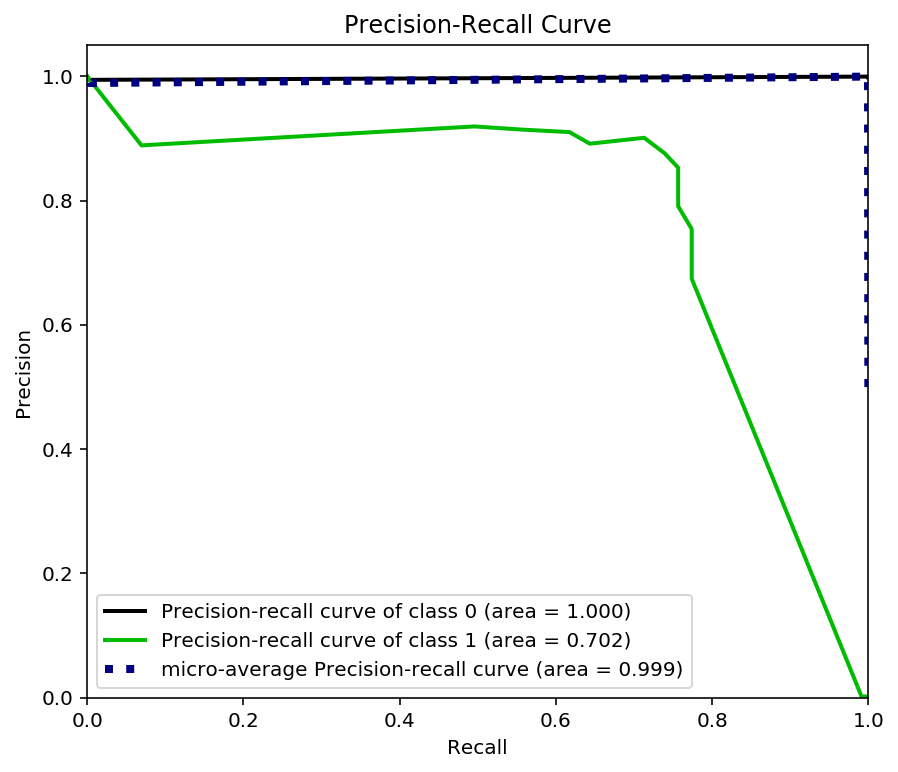

In [428]:
plot_precision_recall(y_test, y_proba, figsize=(7,6));

**Note: There is a difference between average_precision_score and area calculated by plot_precision_recall. In sklearn documentation, we can read that AUPRC calculated by the second function uses linear interpolation and can be a little bit too optimistic, so we stick to average_precision_score.**

In [429]:
# best grid tree visualization
dot_data = StringIO()
export_graphviz(decision_tree=model,
               out_file=dot_data, filled=True,
               feature_names=df.drop(['Class'],axis=1).columns)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(value=graph.create_png())

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x07g\x00\x00\x03\x91\x08\x06\x00\x00\x00\xc6Y\xa9\xe…

In [430]:
def plot_importances(est, columns):
    
    importances = est.feature_importances_
    
    fig, ax = plt.subplots(figsize=(10,8))
    ax.barh(columns, importances)
    ax.set_title("Decision tree feature importances")
    
    return fig

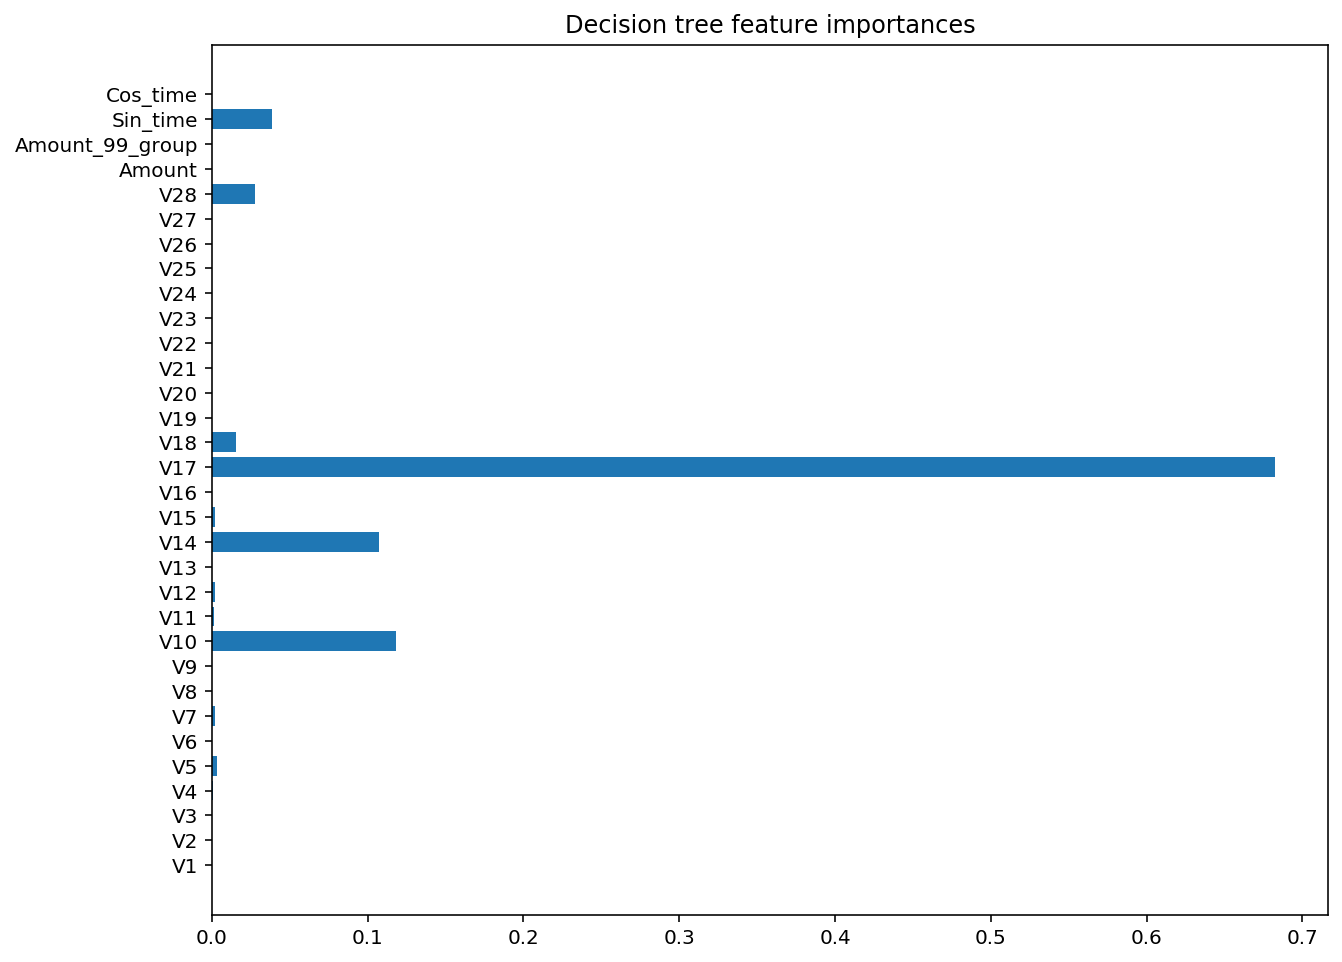

In [431]:
columns = df.drop(["Class"], axis=1).columns
fig = plot_importances(model, columns)

**Note: By plotting feature importances we can see that most of the features were not considered. Sin_time feature, which was created before is the 4th most important feature.**

**Let's check if any other model (20 best models) from the grid will score better than the best model.**

In [432]:
def check_models(grid, results, n, X_train, y_train, X_test, y_test):
    """Fit and Test n best models from grid. Return the best estimator,
    AUPRC of each model and best parameters.
    """
    scores = dict()
    best_score = 0
    for i in range(n):
        param = results.loc[i, "params"]
        clf = grid.best_estimator_.set_params(**param)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        scores[i] = average_precision_score(y_test, y_pred)
        if scores[i] > best_score:
            best_score = scores[i]
            best_est = copy.deepcopy(clf)
            best_params = param
            
    return best_est, scores, best_params

In [433]:
# We will check 20 best models
best_est, scores, best_params = check_models(grid, results, 20,
                                             X_train, y_train,
                                             X_test, y_test)

In [434]:
scores  # We can check which model had the best AUPRC

{0: 0.6430376598974441,
 1: 0.6430376598974441,
 2: 0.6430376598974441,
 3: 0.6430376598974441,
 4: 0.6430376598974441,
 5: 0.6430376598974441,
 6: 0.6430376598974441,
 7: 0.6501768009496286,
 8: 0.6501768009496286,
 9: 0.6501768009496286,
 10: 0.6430376598974441,
 11: 0.6430376598974441,
 12: 0.6587888967451566,
 13: 0.6587888967451566,
 14: 0.6430376598974441,
 15: 0.6430376598974441,
 16: 0.6430376598974441,
 17: 0.6430376598974441,
 18: 0.6430376598974441,
 19: 0.6501768009496286}

In [437]:
best_est

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=7,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=4,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=2019, splitter='best')

In [438]:
best_params

{'min_samples_split': 4, 'min_samples_leaf': 5, 'max_depth': 7}

In [439]:
y_pred = best_est.predict(X_test)
average_precision_score(y_test, y_pred)

0.6587888967451566

In [440]:
f1_score(y_test, y_pred)

0.8058252427184466

**We can see that model with index 12 had the best test AUPRC. The score is 0.015 larger than the best model on CV.**

In [441]:
y_proba = best_est.predict_proba(X_test)

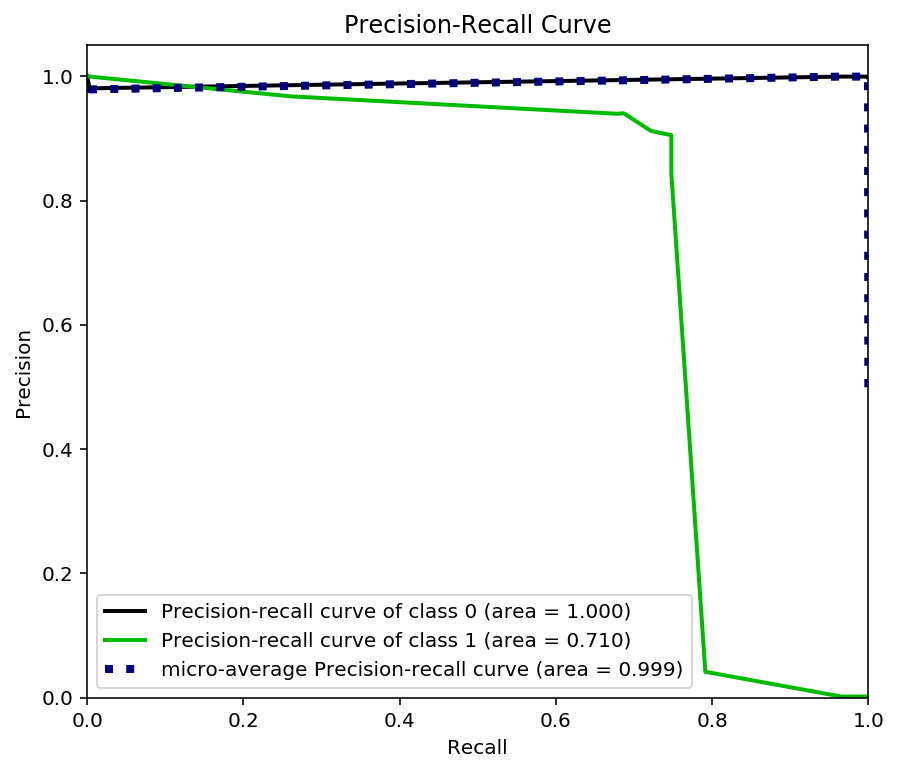

In [442]:
plot_precision_recall(y_test, y_proba, figsize=(7,6));

In [443]:
confusion_matrix(y_test, y_pred)

array([[63959,     8],
       [   32,    83]], dtype=int64)

**This model makes 2 less mistakes than the previous one. The difference isn't significant and with different test set, it might perform worse than the previous model.**

In [444]:
dot_data = StringIO()
export_graphviz(decision_tree=best_est,
               out_file=dot_data, filled=True,
               feature_names=df.drop(['Class'],axis=1).columns)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(value=graph.create_png())

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x0b\x08\x00\x00\x04\x1c\x08\x06\x00\x00\x00\x8b&]Q\x…

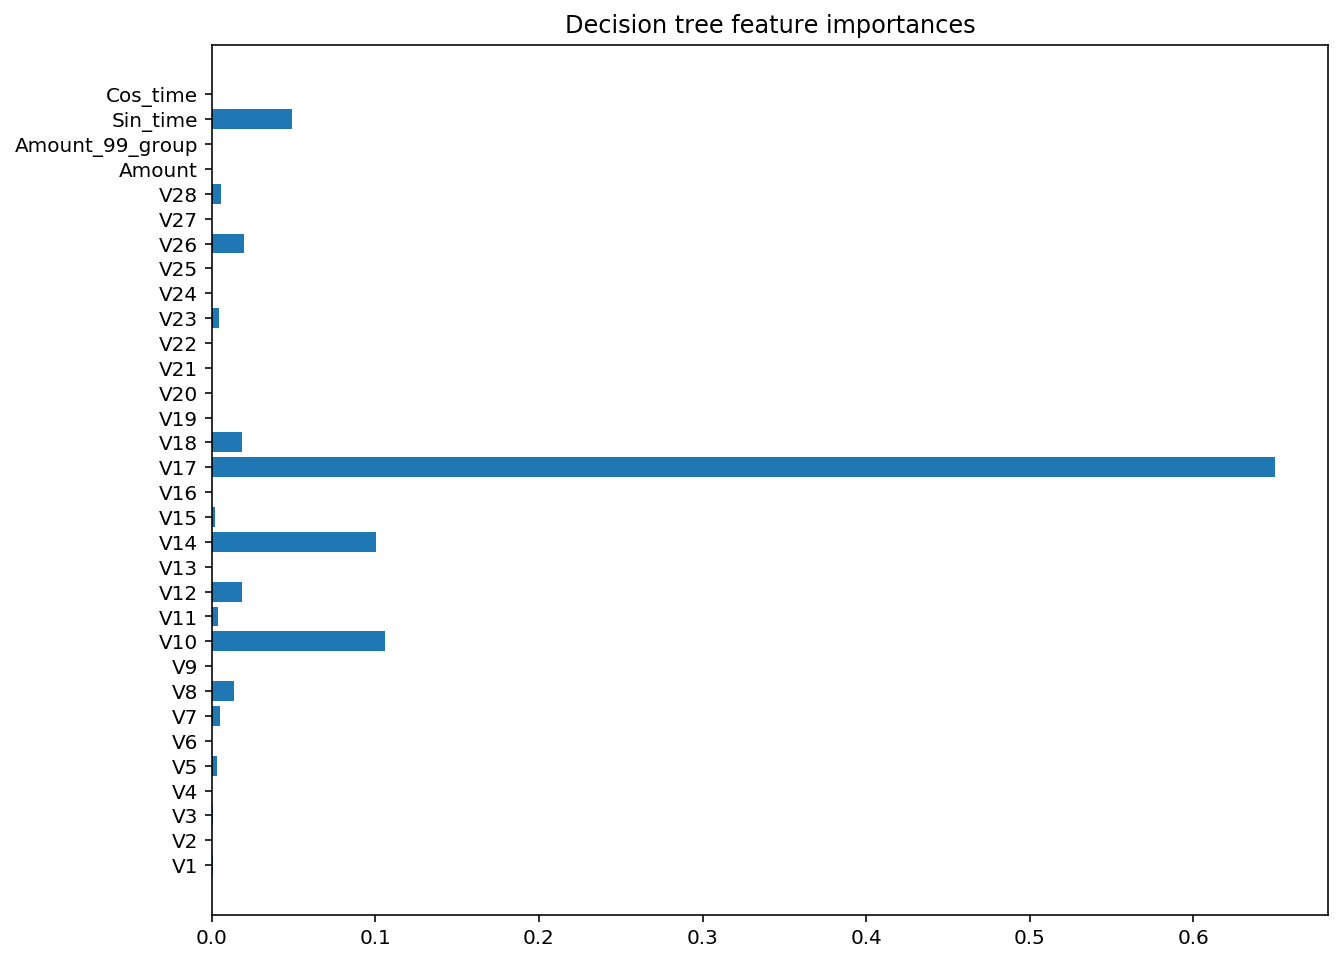

In [445]:
fig = plot_importances(best_est, columns)

**Feature importance graph is similar to the previous one**